In [1]:
from sys import path as syspath
from os import path as ospath
from timeit import default_timer as timer
from joblib import Parallel, delayed
import copy
import json

syspath.append(ospath.join(ospath.expanduser("~"), 'CBSA'))

from cbsa import ReactionSystem

import numpy as np
import matplotlib.pyplot as plt

In [2]:
reactions = [ #["reactants","products",["forward rates"],["backward rates"]]
    ["PMIN A0 + T AK + T AK","T AK _T AK _PMIN A0",["kT","alphaTK"],["qT"]],
    ["PMIN A0 + T AK + T AV","T AK _T AV _PMIN A0",["kT","alphaTK"],["qT"]],    
    ["PMIN A0 + T AV + T AV","T AV _T AV _PMIN A0",["kT"],["qT"]],    
    ["PMIN A1 + T AK + T AK","T AK _T AK _PMIN A1",["kT","alphaTK"],["qT"]],    
    ["PMIN A1 + T AK + T AV","T AK _T AV _PMIN A1",["kT","alphaTK"],["qT"]],    
    ["PMIN A1 + T AV + T AV","T AV _T AV _PMIN A1",["kT"],["qT"]],    
    ["PMIN B0 + T BK + T BK","T BK _T BK _PMIN B0",["kT","alphaTK"],["qT"]],
    ["PMIN B0 + T BK + T BV","T BK _T BV _PMIN B0",["kT","alphaTK"],["qT"]],
    ["PMIN B0 + T BV + T BV","T BV _T BV _PMIN B0",["kT"],["qT"]],
    ["PMIN B1 + T BK + T BK","T BK _T BK _PMIN B1",["kT","alphaTK"],["qT"]],
    ["PMIN B1 + T BK + T BV","T BK _T BV _PMIN B1",["kT","alphaTK"],["qT"]],
    ["PMIN B1 + T BV + T BV","T BV _T BV _PMIN B1",["kT"],["qT"]],
    
    ["T AK _T AV _PMIN A0","T AK _T AV _PMIN A0 + T BK + BFP",["rVK"],[]],
    ["T AK _T AV _PMIN A1","T AK _T AV _PMIN A1 + T AV",["rVK"],[]],
    ["T AV _T AV _PMIN A0","T AV _T AV _PMIN A0 + T BK + BFP",["rVV"],[]],
    ["T AV _T AV _PMIN A1","T AV _T AV _PMIN A1 + T AV",["rVV"],[]],
    ["T BK _T BV _PMIN B0","T BK _T BV _PMIN B0 + T AK + mCT",["rVK"],[]],
    ["T BK _T BV _PMIN B1","T BK _T BV _PMIN B1 + T BV",["rVK"],[]],
    ["T BV _T BV _PMIN B0","T BV _T BV _PMIN B0 + T AK + mCT",["rVV"],[]],
    ["T BV _T BV _PMIN B1","T BV _T BV _PMIN B1 + T BV",["rVV"],[]],
    
    ["PCMV PIP0 + PI","PCMV PIP0 + PI + T BK",["rCMV"],[]],
    ["PCMV PIP1 + PI","PCMV PIP1 + PI + T AV",["rCMV"],[]],
    ["PCMV E0 + ER","PCMV E0 + ER + T AK",["rCMV"],[]],
    ["PCMV E1 + ER","PCMV E1 + ER + T BV",["rCMV"],[]],
    ["PCMV PIP0","PCMV PIP0 + T BK",["rCMV","lCMV"],[]],
    ["PCMV PIP1","PCMV PIP1 + T AV",["rCMV","lCMV"],[]],
    ["PCMV E0","PCMV E0 + T AK",["rCMV","lCMV"],[]],
    ["PCMV E1","PCMV E1 + T BV",["rCMV","lCMV"],[]],
    ["T AK","",["dT"],[]],
    ["T AV","",["dT"],[]],
    ["T BK","",["dT"],[]],
    ["T BV","",["dT"],[]],
    ["BFP","",["dBFP"],[]],
    ["mCT","",["dmCT"],[]]    
]

rates = {
    "rCMV":1e-4,   #nmols/s
    "rVV":1e-4,   #nmols/s
    "rVK":1e-6,   #nmols/s
    "lCMV":1e-2,   #nmols/s
    "kT": 1.,   #nmols/s
    "alphaTK":3.05,   #N/A
    "qT":1e-4,   #nmols/s
    "dT":1e-5,   #nmols/s
    "dBFP":1e-5,   #nmols/s
    "dmCT":1e-5   #nmols/s
}

initial_mols = {
    "PCMVE0":10,
    "PCMVE1":10,
    "PCMVPIP0":10,
    "PCMVPIP1":10,
    "PMINA0":10,
    "PMINA1":10,
    "PMINB0":10,
    "PMINB1":10
}

mols = []
for i in range(len(reactions)):
    reactions[i][0] = list(filter(None,reactions[i][0].replace(" ","").split("+")))
    reactions[i][1] = list(filter(None,reactions[i][1].replace(" ","").split("+")))
    
    mols+=reactions[i][0]+reactions[i][1]
mols = list(set(mols))
print(mols)

mol_idx = {mols[i]:i for i in range(len(mols))}

['PCMVPIP0', 'ER', 'TBV', 'TAV_TAV_PMINA0', 'TBK_TBK_PMINB0', 'TAV', 'PCMVPIP1', 'TBV_TBV_PMINB1', 'TBK_TBV_PMINB0', 'TAK_TAV_PMINA0', 'PMINA0', 'PMINA1', 'TBK_TBK_PMINB1', 'TBV_TBV_PMINB0', 'PCMVE1', 'BFP', 'TAK_TAV_PMINA1', 'PCMVE0', 'mCT', 'TAV_TAV_PMINA1', 'PMINB1', 'PMINB0', 'TBK', 'TAK', 'TAK_TAK_PMINA1', 'TAK_TAK_PMINA0', 'TBK_TBV_PMINB1', 'PI']


In [3]:
n_mols = len(mols)
n_react = 0

for r in reactions:
    n_react += 1
    if len(r[3]):
        n_react += 1
        
print("n_mols ",n_mols)
print("n_react ",n_react)
        
S = [[0 for j in range(n_react)] for i in range(n_mols)]
R = [[0 for j in range(n_react)] for i in range(n_mols)]

k = [0. for j in range(n_react)]
x = [0 for i in range(n_mols)]

for key,value in initial_mols.items():
    x[mol_idx[key]] = value  


i = 0
for r in range(len(reactions)):
    modificators = list(set(reactions[r][0]) & set(reactions[r][1]))
    for m in modificators:
        R[mol_idx[m]][i] += 1
    for m in reactions[r][0]:
        S[mol_idx[m]][i] -= 1
    for m in reactions[r][1]:
        S[mol_idx[m]][i] += 1
    k[i] = np.prod(np.array([rates[j] for j in reactions[r][2]]))
    i+=1
    if len(reactions[r][3]):
        for m in modificators:
            R[mol_idx[m]][i] += 1
        for m in reactions[r][1]:
            S[mol_idx[m]][i] -= 1
        for m in reactions[r][0]:
            S[mol_idx[m]][i] += 1
        k[i] = np.prod(np.array([rates[j] for j in reactions[r][3]]))
        i+=1
        
#cell_volume = 1e3*(4./3.)*pi*np.power(13e-6,3) #11-15 micrometers https://bionumbers.hms.harvard.edu/bionumber.aspx?s=n&v=1&id=108918
#factor = N_A*1e-9*cell_volume
#k = [j*factor for j in k]

#print_reaction = 25
#print(np.array(S)[:,print_reaction])
#print(np.array(R)[:,print_reaction])
print(k)
cbsa = ReactionSystem(S,R,np.int64)

cbsa.setup()
cbsa.set_x(x)
cbsa.set_k(k)

n_mols  28
n_react  46
[3.05, 0.0001, 3.05, 0.0001, 1.0, 0.0001, 3.05, 0.0001, 3.05, 0.0001, 1.0, 0.0001, 3.05, 0.0001, 3.05, 0.0001, 1.0, 0.0001, 3.05, 0.0001, 3.05, 0.0001, 1.0, 0.0001, 1e-06, 1e-06, 0.0001, 0.0001, 1e-06, 1e-06, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 1.0000000000000002e-06, 1.0000000000000002e-06, 1.0000000000000002e-06, 1.0000000000000002e-06, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05, 1e-05]


In [107]:
max_dt = 1.0
alpha = 0.5
batch_steps = 100
t1 = 3.0*24*3600
t2 = 13.0*24*3600
t_total = t1+t2

def run_model_no_inducer(model,exp_id,output_file=None):
    start = timer()
    data = []
    local_model = copy.deepcopy(model)
    
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t_total,batch_steps=batch_steps)
    data += np.array(local_model.simulation_data).tolist()
    time_elapsed = timer() - start
    if output_file:
        with open(str(exp_id)+"_"+output_file,"w") as f:
            f.write(json.dumps(data))
    return time_elapsed

        
def run_model_ER(model,exp_id,output_file=None):
    start = timer()
    data = []
    local_model = copy.deepcopy(model)
    local_x = model.get_x()
    local_x[mol_idx["ER"]] = 1000
    local_model.set_x(local_x)
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t_total,batch_steps=batch_steps)
    data += np.array(local_model.simulation_data).tolist()
    time_elapsed = timer() - start
    if output_file:
        with open(str(exp_id)+"_"+output_file,"w") as f:
            f.write(json.dumps(data))
    return time_elapsed
        
def run_model_ER_noER(model,exp_id,output_file=None):
    start = timer()
    data = []
    local_model = copy.deepcopy(model)
    local_x = model.get_x()
    local_x[mol_idx["ER"]] = 1000
    local_model.set_x(local_x)
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t1,batch_steps=batch_steps)
    data += np.array(local_model.simulation_data).tolist()
    time = data[-1][0]
    new_x = data[-1][1:]
    new_x[mol_idx["ER"]] = 0    
    local_model.set_x(new_x)    
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t2,batch_steps=batch_steps)
    new_data = np.array(local_model.simulation_data)
    new_data[:,0]+=time
    data += new_data.tolist()
    time_elapsed = timer() - start
    if output_file:
        with open(str(exp_id)+"_"+output_file,"w") as f:
            f.write(json.dumps(data))
    return time_elapsed
        
def run_model_PI(model,exp_id,output_file=None):
    start = timer()
    data = []
    local_model = copy.deepcopy(model)
    local_x = model.get_x()
    local_x[mol_idx["PI"]] = 1000
    local_model.set_x(local_x)
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t_total,batch_steps=batch_steps)
    data += np.array(local_model.simulation_data).tolist()
    time_elapsed = timer() - start
    if output_file:
        with open(str(exp_id)+"_"+output_file,"w") as f:
            f.write(json.dumps(data))
    return time_elapsed
        
def run_model_PI_noPI(model,exp_id,output_file=None):
    start = timer()
    data = []
    local_model = copy.deepcopy(model)
    local_x = model.get_x()
    local_x[mol_idx["PI"]] = 1000
    local_model.set_x(local_x)
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t1,batch_steps=batch_steps)
    data += np.array(local_model.simulation_data).tolist()
    time = data[-1][0]
    new_x = data[-1][1:]
    new_x[mol_idx["PI"]] = 0    
    local_model.set_x(new_x)    
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t2,batch_steps=batch_steps)
    new_data = np.array(local_model.simulation_data)
    new_data[:,0]+=time
    data += new_data.tolist()
    time_elapsed = timer() - start
    if output_file:
        with open(str(exp_id)+"_"+output_file,"w") as f:
            f.write(json.dumps(data))
    return time_elapsed
        
def run_model_ER_PI(model,exp_id,output_file=None):
    start = timer()
    data = []
    local_model = copy.deepcopy(model)
    local_x = model.get_x()
    local_x[mol_idx["ER"]] = 1000
    local_model.set_x(local_x)
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t1,batch_steps=1000)
    data += np.array(local_model.simulation_data).tolist()
    time = data[-1][0]
    new_x = data[-1][1:]
    new_x[mol_idx["ER"]] = 0
    new_x[mol_idx["PI"]] = 1000
    local_model.set_x(new_x)    
    local_model.setup_simulation(use_opencl=False,alpha=alpha,max_dt=max_dt)
    local_model.compute_simulation(t2,batch_steps=1000)
    new_data = np.array(local_model.simulation_data)
    new_data[:,0]+=time
    data += new_data.tolist()
    time_elapsed = timer() - start
    if output_file:
        with open(str(exp_id)+"_"+output_file,"w") as f:
            f.write(json.dumps(data))
    return time_elapsed
        
def read_data(path):
    with open(path) as f:
        return np.array(json.load(f))

In [15]:
def run_parallel(model,exp,replicates=1):
    if exp=="no_inducer":
        for j in range(replicates):
            run_model_no_inducer(model,j+1,"genetic_switch_sim_no_inducer.json")
    if exp=="ER":
        for j in range(replicates):
            run_model_ER(model,j+1,"genetic_switch_sim_ER.json")
    if exp=="PI":
        for j in range(replicates):
            run_model_PI(model,j+1,"genetic_switch_sim_PI.json")
    if exp=="ER_noER":
        for j in range(replicates):
            run_model_ER_noER(model,j+1,"genetic_switch_sim_ER_noER.json")
    if exp=="PI_noPI":
        for j in range(replicates):
            run_model_PI_noPI(model,j+1,"genetic_switch_sim_PI_noPI.json")
    if exp=="ER_PI":
        for j in range(replicates):
            run_model_ER_PI(model,j+1,"genetic_switch_sim_ER_PI.json")
            
            
experiments = ["no_inducer","ER","PI","ER_noER","PI_noPI","ER_PI"]
Parallel(n_jobs=6)(delayed(run_model_ER_PI)(cbsa,e,50) for e in experiments)
#run_model_no_inducer(cbsa,1,"genetic_switch_no_inducer.json")
#run_model_PI(cbsa,1,"genetic_switch_sim_PI.json")

[None, None, None, None, None, None]

In [109]:
comp_times = Parallel(n_jobs=10)(delayed(run_model_ER_PI)(cbsa,e) for e in range(10))
print(comp_times)

[1198.37566152215, 1199.0212043514475, 1014.1970342490822, 672.4705662271008, 1193.4040241409093, 1050.0323518496007, 702.0422567687929, 1006.6955701606348, 1015.1513703772798, 1191.4750909209251]


In [111]:
print("mean time: ", np.mean(comp_times)/60," +- ",np.std(comp_times)/60)

mean time:  17.07144188427987  +-  3.1009199178744393


In [6]:
from matplotlib import rc
from mpl_toolkits import mplot3d
fontsize = 14
rc('text', usetex=True)
plt.style.use("bmh")
plt.rcParams["font.family"] = "serif"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [28]:
def plot_data(experiment_file):
    cbsa_data = read_data("1_"+experiment_file)
    plt.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['BFP']+1],label='BFP',color=colors[0],alpha=0.3)
    plt.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['mCT']+1],label='mCT',color=colors[1],alpha=0.3)
    for i in range(1,50):
        cbsa_data = read_data(str(i+1)+"_"+experiment_file)
        plt.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['BFP']+1],color=colors[0],alpha=0.3)
        plt.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['mCT']+1],color=colors[1],alpha=0.3)
    plt.xlabel("time (days)")
    plt.ylabel("number of molecules")
    plt.legend()
    plt.show()

/home/burke/anaconda3/envs/gpu/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


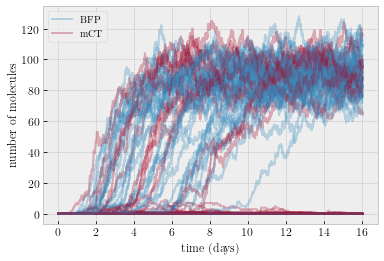

In [29]:
experiment_file = "genetic_switch_sim_no_inducer.json"
plot_data(experiment_file)

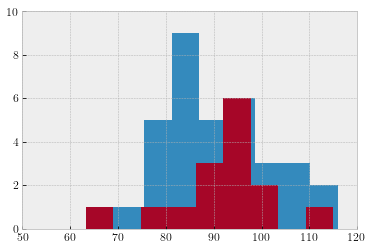

In [42]:
last_points_BFP = []
last_points_mCT = []
for i in range(50):
    cbsa_data = read_data(str(i+1)+"_"+experiment_file)
    last_points_BFP.append(cbsa_data[-1,mol_idx['BFP']+1])
    last_points_mCT.append(cbsa_data[-1,mol_idx['mCT']+1])
    
bins = 20
plt.hist(last_points_BFP,bins=bins,color=colors[0])
plt.hist(last_points_mCT,bins=bins,color=colors[1])
plt.xlim(50,120)
plt.ylim(0,10)
plt.show()

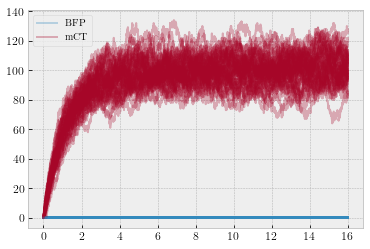

In [21]:
experiment_file = "genetic_switch_sim_ER.json"
plot_data(experiment_file)

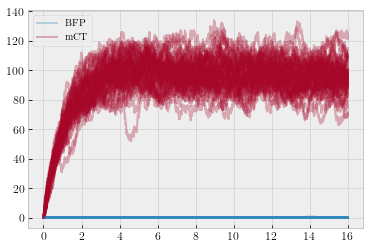

In [22]:
experiment_file = "genetic_switch_sim_ER_noER.json"
plot_data(experiment_file)

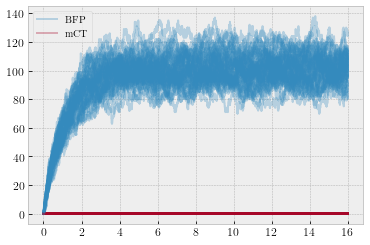

In [23]:
experiment_file = "genetic_switch_sim_PI.json"
plot_data(experiment_file)

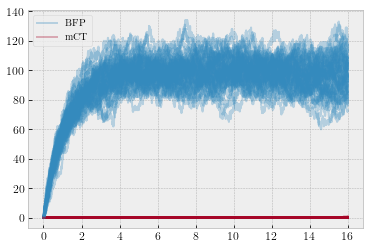

In [26]:
experiment_file = "genetic_switch_sim_PI_noPI.json"
plot_data(experiment_file)

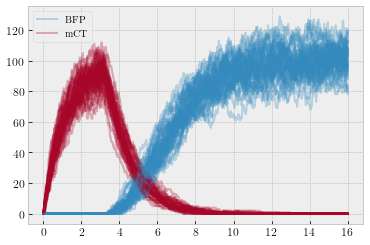

In [27]:
experiment_file = "genetic_switch_sim_ER_PI.json"
plot_data(experiment_file)

In [96]:
def plot_ax(ax,experiment_file,xlabel=True,ylabel=True):
    cbsa_data = read_data("1_"+experiment_file)
    ax.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['BFP']+1],label='BFP',color=colors[0],alpha=0.3)
    ax.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['mCT']+1],label='mCT',color=colors[1],alpha=0.3)
    for i in range(1,50):
        cbsa_data = read_data(str(i+1)+"_"+experiment_file)
        ax.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['BFP']+1],color=colors[0],alpha=0.3)
        ax.plot(cbsa_data[:,0]/(3600.*24),cbsa_data[:,mol_idx['mCT']+1],color=colors[1],alpha=0.3)
    if xlabel: ax.set_xlabel("Time (days)",fontsize=16)
    if ylabel: ax.set_ylabel("Number of Molecules",fontsize=16)

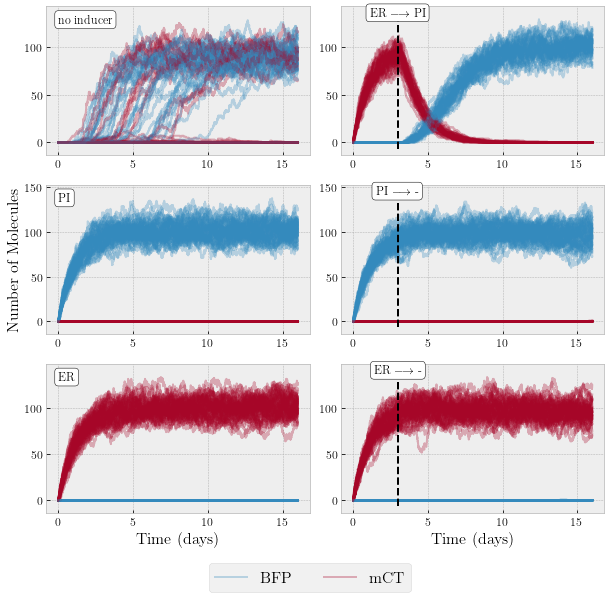

In [97]:
fig = plt.figure(figsize=(10, 8),constrained_layout=False)

gs = fig.add_gridspec(nrows=3, ncols=2)


ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1],sharey=ax0)
ax2 = fig.add_subplot(gs[1,0],sharex=ax0)
ax3 = fig.add_subplot(gs[1,1],sharey=ax2,sharex=ax1)
ax4 = fig.add_subplot(gs[2,0],sharex=ax0)
ax5 = fig.add_subplot(gs[2,1],sharey=ax4,sharex=ax1)

plot_ax(ax0,"genetic_switch_sim_no_inducer.json",xlabel=False,ylabel=False)
plot_ax(ax1,"genetic_switch_sim_ER_PI.json",xlabel=False,ylabel=False)
plot_ax(ax2,"genetic_switch_sim_PI.json",xlabel=False)
plot_ax(ax3,"genetic_switch_sim_PI_noPI.json",xlabel=False,ylabel=False)
plot_ax(ax4,"genetic_switch_sim_ER.json",ylabel=False)
plot_ax(ax5,"genetic_switch_sim_ER_noER.json",ylabel=False)

ax0.text(0,ax0.get_ylim()[1]-10,r'no inducer',fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax1.plot([3.,3.],ax1.get_ylim(),color="black",linestyle="--")
ax1.text(1.1,ax1.get_ylim()[1]-10,r'ER $\longrightarrow$ PI',fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax2.text(0,ax2.get_ylim()[1]-10,r'PI',fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax3.plot([3.,3.],ax3.get_ylim(),color="black",linestyle="--")
ax3.text(1.5,ax3.get_ylim()[1]-10,r'PI $\longrightarrow$ -',fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax4.text(0,ax4.get_ylim()[1]-10,r'ER',fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax5.plot([3.,3.],ax5.get_ylim(),color="black",linestyle="--")
ax5.text(1.4,ax5.get_ylim()[1]-10,r'ER $\longrightarrow$ -',fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

ax4.legend(loc='upper center',bbox_to_anchor=(1., -0.28), ncol=2,fontsize=16)

plt.subplots_adjust(bottom=0., wspace=0.12)
plt.savefig("genetic_switch.png",dpi=300, bbox_inches='tight')
plt.show()

In [105]:
#GillesPy
import gillespy2 as glp
from gillespy2.solvers.numpy.basic_ode_solver import BasicODESolver
from gillespy2.solvers.numpy.basic_tau_leaping_solver import BasicTauLeapingSolver
from gillespy2.solvers.numpy.ssa_solver import NumPySSASolver

from cbsa2models import cbsa2gillespy

def run_gillespy(cbsa_model,method="Direct",output="time"):
    methods = {"Direct":NumPySSASolver,"Tauleap":BasicTauLeapingSolver,"ODE":BasicODESolver}
    gilles = cbsa2gillespy(cbsa_model)
    gilles.timespan(np.cumsum(np.array([max_dt for i in range(int(t_total/max_dt))])))
    start = timer()
    result = gilles.run(solver = methods[method],number_of_trajectories=1)
    time_elapsed = timer() - start
    gilles_ssa_data = np.column_stack([result['time']]+[result['M'+str(i)] for i in range(1,cbsa_model.exp_n_molecules)])
    return gilles_ssa_data

In [106]:
ssa_data = run_gillespy(cbsa)

ReactionError: Reaction: A mass-action reaction cannot involve more than two of one species or one of two species.